<a href="https://colab.research.google.com/github/0616039/IMVFX_HW2/blob/main/IMVFX_HW2_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework2 - Conditional Generative Adversarial Network (cGAN)
This is the sample code of homework 2 of the IMVFX course by Prof. I-Chen Lin

In this homework, you are required to build a conditional generative adversarial network for image generation.

Should you have any question, contact TA via <br/> ee81280@gmail.com


Sample code for cGAN, include the structure and train function.
You can start from this file or write your own structure and train function.
You can also modify anything in this file for training.

What you need to do:
1. Load your dataset.
2. Train the cGAN model and generate images with different conditions.
3. Plot the training loss of generator and discriminator.
4. Use trained cGAN model to generate images with conditions.


If you not familiar with Colab, [here](https://colab.research.google.com/drive/1ecb4-tImhe2CD6DSzxJtt63CAxt2c_Ap) provide the basic Colab knowledge needed to finish this homework.

# Set up the environment


## Packages Installation

In [ ]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

## Import Packages

First, we need to import packages that will be used later.

In [ ]:
import os
import glob 
import random
from PIL import Image

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(123)

# Hyperparameters and Initialization
Let’s define some inputs for the run later:

In [ ]:
# Root directory for dataset
dataroot = "dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# The size of images
image_size = 28

# Number of channels in the training images. For gray images this is 1
nc = 1

# Size of z latent vector 
nz = 100

# Number of image classes (i.e. 0-9)
nclass = 10

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# The weight for L1 loaa
lamb = 100

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Save checkpoints every few epochs
save_steps = 5

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# log(img), checkpoints and results directory
log_dir = os.path.join(workspace_dir, 'logs/cGAN')    # For evaluation results
ckpt_dir = os.path.join(workspace_dir, 'checkpoints/cGAN')    # For trained model weights
result_dir = os.path.join(workspace_dir, 'results/cGAN')    # For testing results
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

# Load training data

In [ ]:
# Define training and testing data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the train dataset
train_dataset = dset.MNIST(dataroot, train=True, download=True, transform=transform)
# Create the train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



## Show some training datas

In [ ]:
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

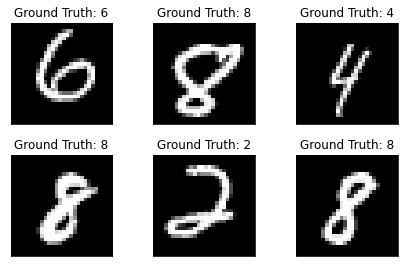

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Setup Model
Here, we use conditional generative adversarial nets as the model structure. Feel free to modify your own model structure.

## Weight Initialization

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(net):
    def init_func(m):
      classname = m.__class__.__name__
      if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
      elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
      elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
      
    net.apply(init_func)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # The size of generator input.
        input_dim = nz + nclass
        # The size of generator output.
        output_dim = image_size*image_size

        # It will have a 10-dimensional encoding for all the 10 digits.
        self.label_embedding = nn.Embedding(nclass, nclass)
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], dim=1)
        output = self.main(x)
        return output

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # The size of discriminator input.
        input_dim = image_size*image_size + nclass
        # The size of discriminator output.
        output_dim = 1
        # It will have a 10-dimensional encoding for all the 10 digits.
        self.label_embedding = nn.Embedding(nclass, nclass)

        self.main = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )


    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], dim=1)
        output = self.main(x)

        return output

# Train

## Initialization for cGAN

In [ ]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
weights_init(netG)

# Print the model
print(netG)

Generator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
weights_init(netD)

# Print the model
print(netD)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [ ]:
# Initialize Loss functions
criterionGAN = nn.BCELoss().to(device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.

# Create the latent vectors and condition labels that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(100, nz, device=device)
fixed_labels = torch.randint(0, 10, (100,)).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


## Training loop

Starting Training Loop...


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.42it/s  0.2723  3.8504    1    937              

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

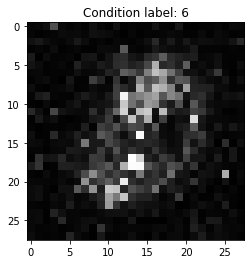

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  42.12it/s  0.1739  2.8962    2    1875             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

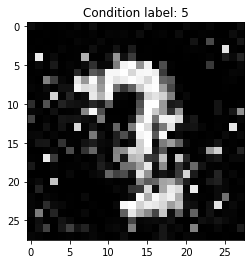

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.80it/s  0.6409  1.4801    3    2813             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

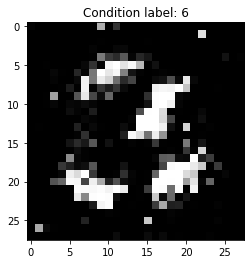

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.73it/s  0.3122  2.5022    4    3751             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

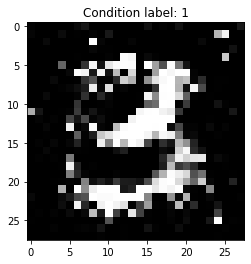

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.46it/s  0.3268  2.4656    5    4689             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

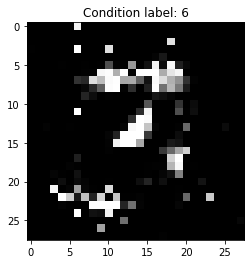

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.80it/s  0.5774  1.2205    6    5627             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

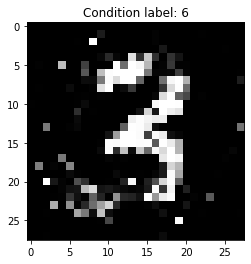

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.73it/s  0.4238  1.6471    7    6565             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

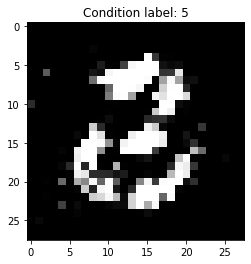

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.00it/s  0.5059  1.2658    8    7503             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

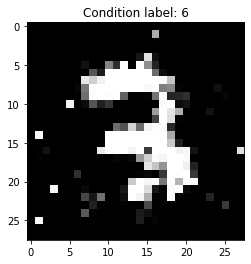

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.72it/s  0.5592  1.3344    9    8441             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

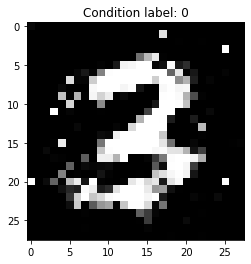

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.48it/s  0.5185  1.2337   10    9379             

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

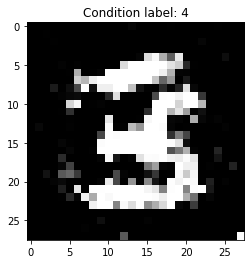

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.88it/s  0.6678  1.1323   11    10317            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

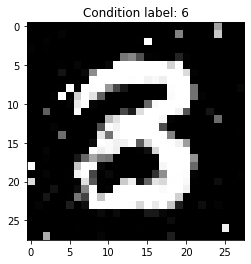

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.40it/s  0.7488  1.0173   12    11255            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

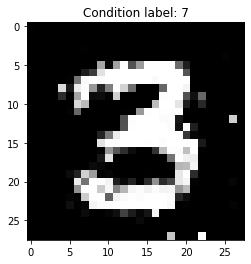

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.19it/s  0.6027  1.0766   13    12193            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

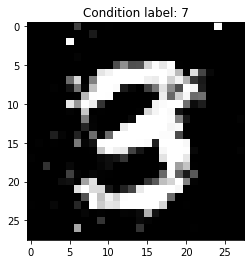

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.14it/s  0.6942  0.9349   14    13131            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

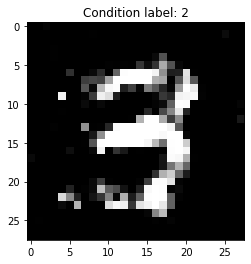

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  40.98it/s  0.5228  0.8627   15    14069            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

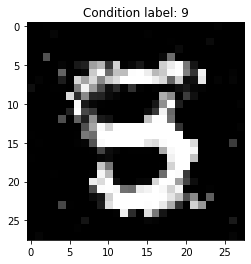

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.09it/s  0.5981  1.0106   16    15007            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

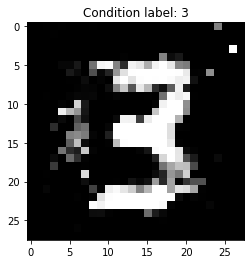

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:22<00:00:00  41.01it/s  0.6367  1.1329   17    15945            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

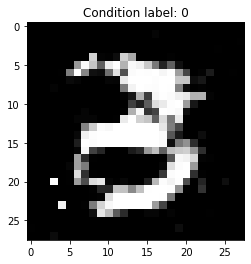

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  40.48it/s  0.6228  1.2004   18    16883            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

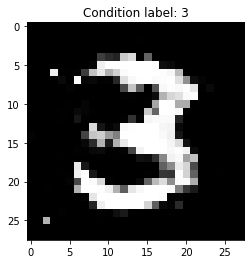

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  40.19it/s  0.6546  1.0196   19    17821            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

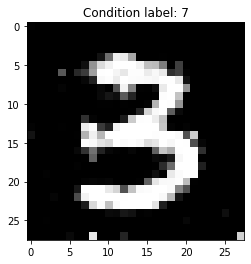

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.83it/s  0.5729  0.8567   20    18759            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

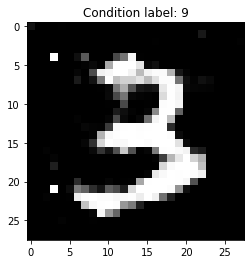

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  40.20it/s  0.6187  0.8087   21    19697            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

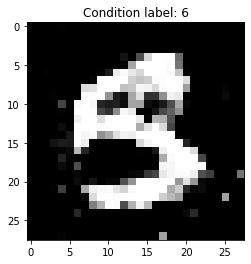

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.87it/s  0.5759  0.9559   22    20635            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

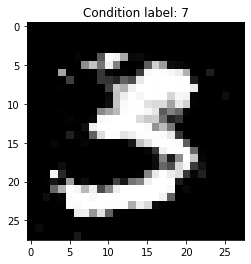

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.94it/s  0.6152  0.9687   23    21573            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

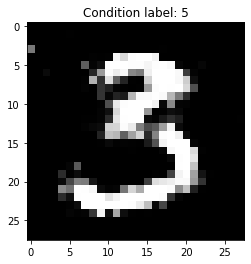

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.85it/s  0.6092  0.7392   24    22511            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

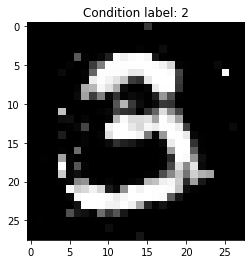

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  40.52it/s  0.639   1.0646   25    23449            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

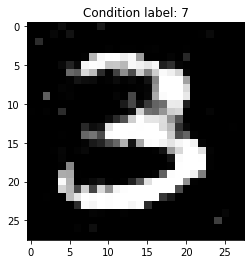

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  40.07it/s  0.6372  1.0922   26    24387            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

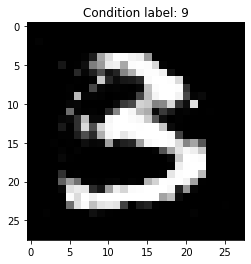

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.88it/s  0.7302  0.9389   27    25325            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

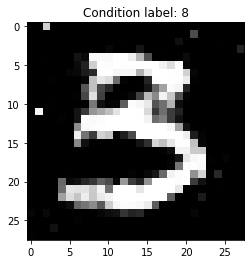

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.71it/s  0.6332  0.9348   28    26263            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

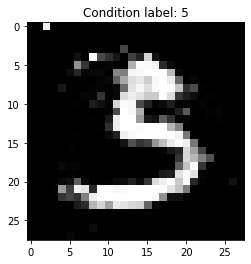

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.67it/s  0.6585  1.0994   29    27201            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

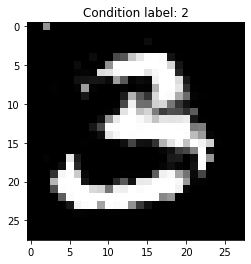

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.64it/s  0.6237  1.1154   30    28139            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

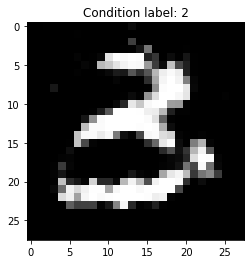

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.68it/s  0.6993  0.8849   31    29077            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

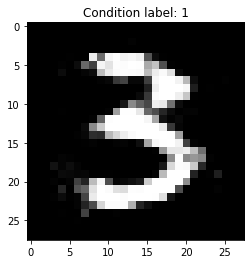

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.32it/s  0.6306  0.8974   32    30015            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

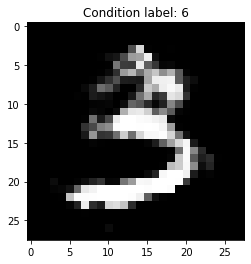

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.64it/s  0.6287  0.8108   33    30953            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

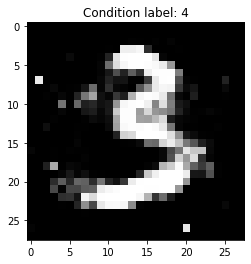

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.82it/s  0.6448  0.8358   34    31891            

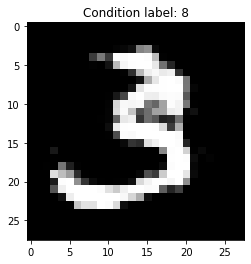

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.98it/s  0.7063  0.7284   35    32829            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

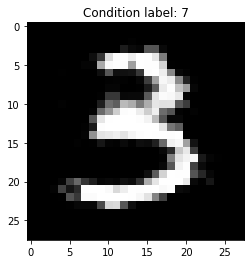

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.59it/s  0.6539  0.7676   36    33767            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

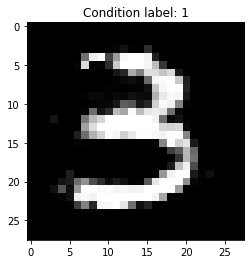

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.50it/s  0.6201  0.925    37    34705            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

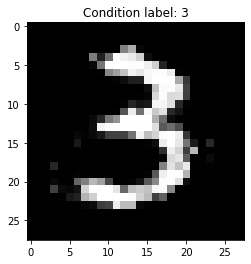

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.41it/s  0.6517  0.9878   38    35643            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

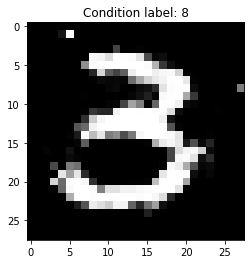

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:24<00:00:00  38.83it/s  0.6041  0.954    39    36581            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

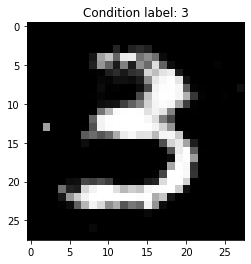

Evaluation done!


  Iters     Elapsed Time       Speed    Loss_D  Loss_G  Epoch  Step             
 938/938  00:00:23<00:00:00  39.52it/s  0.6528  0.869    40    37519            

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

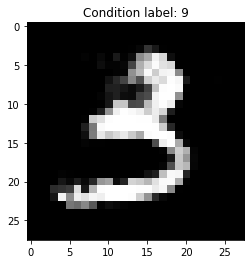

Evaluation done!


In [ ]:
err_G = []
err_D = []

# Training Loop
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    progress_bar = qqdm(train_dataloader)
    netG.train()
    netD.train()
    # For each batch in the dataloader
    for i, data in enumerate(progress_bar):

        ############################
        # (1) Update D network
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        true_img = data[0].view(-1, image_size*image_size).to(device)
        b_size = true_img.size(0)
        digit_labels = data[1].to(device)
        # Forward pass real batch through D
        pred_real = netD(true_img, digit_labels).view(-1)
        # Calculate loss on all-real batch
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        errD_real = criterionGAN(pred_real, label)

        ## Train with all-fake batch
        # Generate fake image batch with G
        noise = torch.randn(b_size, nz, device=device)
        fake_labels = torch.randint(0, 10, (b_size,), device=device)
        fake = netG(noise, fake_labels)
        # Classify all fake batch with D
        pred_fake = netD(fake.detach(), fake_labels).view(-1)
        # Calculate D's loss on the all-fake 
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        errD_fake = criterionGAN(pred_fake, label)

        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake)*0.5
        # Calculate the gradients for this batch
        errD.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        fake = netG(noise, fake_labels)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        pred_fake = netD(fake, fake_labels).view(-1)
        label.fill_(real_label)   # fake labels are real for generator cost
        # Calculate G's loss based on this output
        errG = criterionGAN(pred_fake, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()

        # Output training stats\
        # Set the info of the progress bar
        # Note that the value of the GAN loss is not directly related to
        # the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(errD.item(), 4),
            'Loss_G': round(errG.item(), 4),
            'Epoch': epoch+1,
            'Step': iters,
        })
        err_G.append(round(errD.item(), 4))
        err_D.append(round(errG.item(), 4))
        iters += 1

    # Evaluation 
    netG.eval()
    with torch.no_grad():
        generated_imgs = netG(fixed_noise, fixed_labels)
        show_imgs = generated_imgs.cpu().view(-1, image_size, image_size)
        # Save evaluation results
        if (epoch+1) % save_steps == 0:
            filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
            img_samples = (generated_imgs.view(-1, 1, image_size, image_size).data + 1) / 2.0
            torchvision.utils.save_image(img_samples, filename, nrow=10)
        for x in show_imgs:
            plt.title('Condition label: {}'.format(str(fake_labels[0].item())))
            plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
            plt.show()
            break
    print('Evaluation done!')

    # Save the checkpoints.
    if (epoch+1) % save_steps == 0:
        netG_out_path = os.path.join(ckpt_dir, 'netG_epoch_{}.pth'.format(epoch+1))
        netD_out_path = os.path.join(ckpt_dir, 'netD_epoch_{}.pth'.format(epoch+1))
        torch.save(netG.state_dict(), netG_out_path)
        torch.save(netD.state_dict(), netD_out_path)

## Plot the generator and discriminator loss

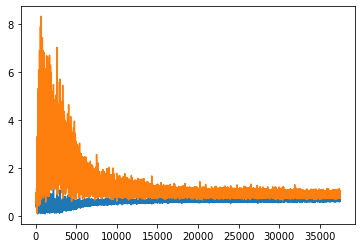

In [ ]:
###############################################################################
# TODO: Plot the training loss value of discriminator and generator
# Implementation 1-2
###############################################################################
import matplotlib.pyplot as plt
plt.plot(err_G)
plt.plot(err_D)
plt.show()

# Inference

The trained model should has been saved in the directory(ckpt_dir) you specified.

Use the trained model to generate images with condition!

## Load trained model

In [ ]:
import torch

# load gernerator
device = torch.device("cuda")
netG = Generator()
netG.load_state_dict(torch.load(os.path.join(ckpt_dir, 'netG_epoch_{}.pth'.format(num_epochs))))
netG.eval()
netG.to(device)

Generator(
  (label_embedding): Embedding(10, 10)
  (main): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

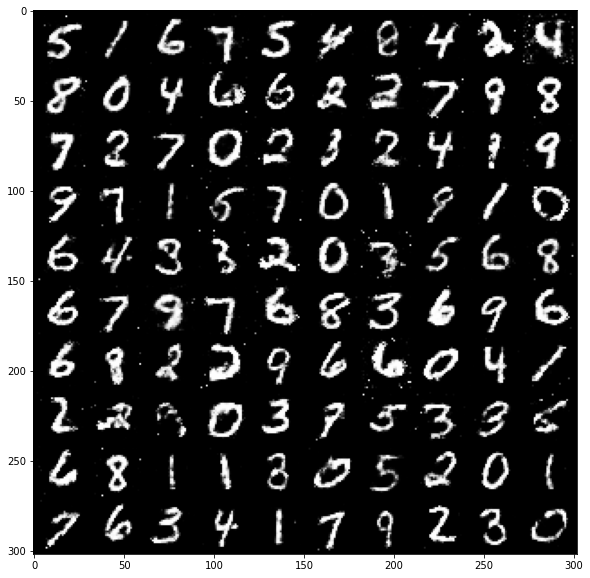

In [ ]:
###############################################################################
# TODO: Store the generated 10*10 grid images
# Implementation 1-3
###############################################################################

# Generate 100 images and make a grid to save them.
n_output = 100
fixed_noise = torch.randn(100, nz, device=device)
fixed_labels = torch.randint(0, nclass, (100,)).to(device)
imgs_sample = netG(fixed_noise, fixed_labels)
img_samples = (imgs_sample.view(-1, 1, image_size, image_size).data + 1) / 2.0
result_dir = os.path.join(workspace_dir, 'results/cGAN')
filename = os.path.join(result_dir, 'result.jpg')

# Show the images in notebook.
grid_img = torchvision.utils.make_grid(img_samples, nrow=10)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.cpu().permute([1, 2, 0]))
### 
#plt.savefig(filename)  
###
plt.show()


torchvision.utils.save_image(grid_img, filename, nrow=10)



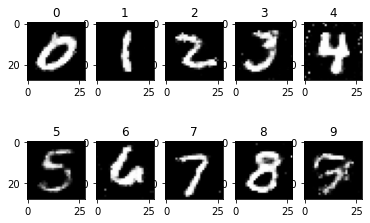

In [ ]:
###############################################################################
# TODO: Generate images with specified condition labels
# Implementation 1-4
###############################################################################
filename = os.path.join(result_dir, 'result_label.jpg')
special_labels = [0,1,2,3,4,5,6,7,8,9]
for num in special_labels:
  plt.subplot(2, 5, num+1)
  num_labels = torch.tensor([num]).to(device)
  fixed_noise = torch.randn(1, nz, device=device)
  special_sample = netG(fixed_noise, num_labels)
  special_samples = (special_sample.view(-1, 1, image_size, image_size).data + 1) / 2.0
  grid_img2 = torchvision.utils.make_grid(special_samples, nrow=10)
  plt.title(str(num))
  plt.imshow(grid_img2.cpu().permute([1, 2, 0]))
plt.savefig(filename)
plt.show()